# 小车上山 MoutainCar-v0

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import tensorflow as tf
from tensorflow import keras
try: # tf2
    tf.random.set_seed(0)
    from tensorflow.keras.initializers import GlorotUniform
except: # tf1
    tf.random.set_random_seed(0)
    from tensorflow import glorot_uniform_initializer as GlorotUniform
import matplotlib.pyplot as plt

### 环境使用

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.unwrapped.min_position, 
        env.unwrapped.max_position)))
print('速度范围 = {}'.format((-env.unwrapped.max_speed,
        env.unwrapped.max_speed)))
print('目标位置 = {}'.format(env.unwrapped.goal_position))

观测空间 = Box(2,)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


一直向右，不能成功

失败退出


D:\Programs\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


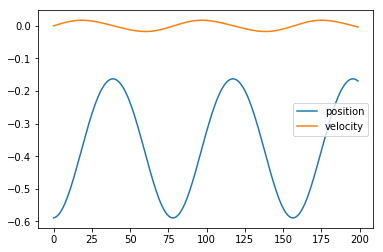

In [3]:
positions, velocities = [], []
observation = env.reset()
while True:
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print('成功到达')
else:
    print('失败退出')

# 绘制位置和速度图像
fig, ax = plt.subplots()
ax.plot(positions, label='position')
ax.plot(velocities, label='velocity')
ax.legend()
fig.show();

### 线性近似最优策略求解
砖瓦编码

In [4]:
class TileCoder:
    def __init__(self, layers, features):
        self.layers = layers
        self.features = features
        self.codebook = {}
    
    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.features: # 冲突处理
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
        
    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) /
                    self.layers) for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

SARSA 算法

In [5]:
class SARSAAgent:
    def __init__(self, env, layers=8, features=1893, gamma=1.,
                learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n # 动作数
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - \
                env.observation_space.low # 观测空间范围
        self.encoder = TileCoder(layers, features) # 砖瓦编码器
        self.w = np.zeros(features) # 权重
        self.gamma = gamma # 折扣
        self.learning_rate = learning_rate # 学习率
        self.epsilon = epsilon # 探索
        
    def encode(self, observation, action): # 编码
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action): # 动作价值
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation): # 判决
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in
                    range(self.action_n)]
            return np.argmax(qs)
        
    def learn(self, observation, action, reward,
            next_observation, done, next_action): # 学习
        u = reward + (1. - done) * self.gamma * \
                self.get_q(next_observation, next_action)
        td_error = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * td_error)

In [6]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation) # 终止状态时此步无意义
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done, next_action)
        if done:
            break
        observation, action = next_observation, next_action
    return episode_reward

平均回合奖励 = -13469.0 / 100 = -134.69


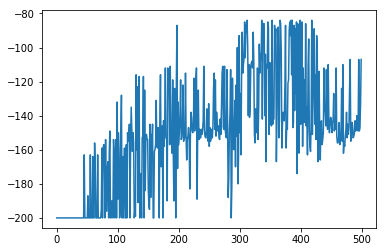

In [7]:
agent = SARSAAgent(env)

# 训练
episodes = 500
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

SARSA($\lambda $)算法

In [8]:
class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, layers=8, features=1893, gamma=1.,
            learning_rate=0.03, epsilon=0.001, lambd=0.9):
        super().__init__(env=env, layers=layers, features=features,
                gamma=gamma, learning_rate=learning_rate, epsilon=epsilon)
        self.lambd = lambd
        self.z = np.zeros(features) # 初始化资格迹
        
    def learn(self, observation, action, reward, next_observation, done,
            next_action):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(next_observation, next_action))
            self.z *= (self.gamma * self.lambd)
            features = self.encode(observation, action)
            self.z[features] = 1. # 替换迹
        td_error = u - self.get_q(observation, action)
        self.w += (self.learning_rate * td_error * self.z)
        if done:
            self.z = np.zeros_like(self.z) # 为下一回合初始化资格迹

平均回合奖励 = -10323.0 / 100 = -103.23


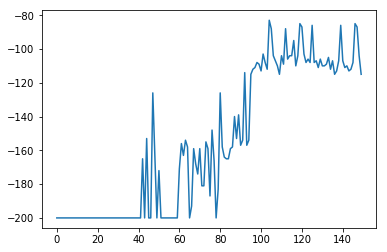

In [9]:
agent = SARSALambdaAgent(env)

# 训练
episodes = 150
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

绘制价值和策略

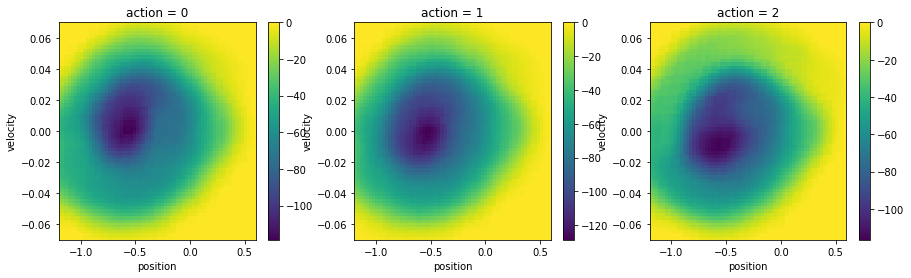

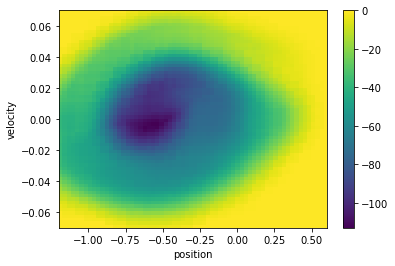

In [10]:
poses = np.linspace(env.unwrapped.min_position,
          env.unwrapped.max_position, 128)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 128)
positions, velocities = np.meshgrid(poses, vels)

# 绘制动作价值估计

@np.vectorize
def get_q(position, velocity, action):
    return agent.get_q((position, velocity), action)

q_values = np.empty((len(poses), len(vels), 3))
for action in range(3):
    q_values[:, :, action] = get_q(positions, velocities, action)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for action, ax in enumerate(axes):
    c = ax.pcolormesh(positions, velocities, q_values[:, :, action])
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    fig.colorbar(c, ax=ax)
    ax.set_title('action = {}'.format(action))
fig.show();

# 绘制状态价值估计

v_values = q_values.max(axis=-1)

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(positions, velocities, v_values)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax)
fig.show();

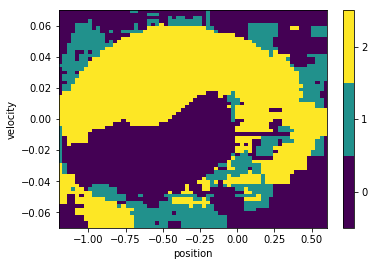

In [11]:
# 绘制动作估计

@np.vectorize
def decide(position, velocity):
    return agent.decide((position, velocity))

q_values = np.empty((len(poses), len(vels), 3))
action_values = decide(positions, velocities)

fig, ax = plt.subplots()
c = ax.pcolormesh(positions, velocities, action_values)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax, boundaries=[-.5, .5, 1.5, 2.5], ticks=[0, 1, 2])
fig.show();

### 深度 Q 网络求解最优策略
经验回放

In [12]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['observation', 'action', 'reward',
                'next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

DQN

In [13]:
class DQNAgent:
    def __init__(self, env, net_kwargs={}, gamma=0.99, epsilon=0.001,
             replayer_capacity=10000, batch_size=64):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity) # 经验回放
         
        self.evaluate_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **net_kwargs) # 评估网络
        self.target_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **net_kwargs) # 目标网络

        self.target_net.set_weights(self.evaluate_net.get_weights())

    def build_network(self, input_size, hidden_sizes, output_size,
                activation=tf.nn.relu, output_activation=None,
                learning_rate=0.01): # 构建网络
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = dict(input_shape=(input_size,)) if not layer else {}
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0), **kwargs))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation, 
                kernel_initializer=GlorotUniform(seed=0))) # 输出层
        optimizer = keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=optimizer)
        return model
        
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,
                done) # 存储经验

        observations, actions, rewards, next_observations, dones = \
                self.replayer.sample(self.batch_size) # 经验回放

        next_qs = self.target_net.predict(next_observations)
        next_max_qs = next_qs.max(axis=-1)
        us = rewards + self.gamma * (1. - dones) * next_max_qs
        targets = self.evaluate_net.predict(observations)
        targets[np.arange(us.shape[0]), actions] = us
        self.evaluate_net.fit(observations, targets, verbose=0)

        if done: # 更新目标网络
            self.target_net.set_weights(self.evaluate_net.get_weights())

    def decide(self, observation): # epsilon贪心策略
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        qs = self.evaluate_net.predict(observation[np.newaxis])
        return np.argmax(qs)

In [14]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -13458.0 / 100 = -134.58


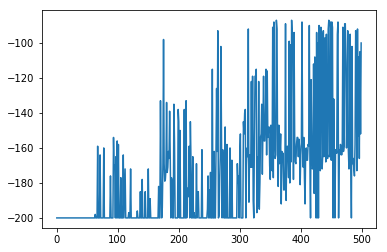

In [15]:
net_kwargs = {'hidden_sizes' : [16,], 'learning_rate' : 0.01}
agent = DQNAgent(env, net_kwargs=net_kwargs)

# 训练
episodes = 500
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

双重深度 Q 网络

In [16]:
class DoubleDQNAgent(DQNAgent):
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,
                done) # 存储经验
        observations, actions, rewards, next_observations, dones = \
                self.replayer.sample(self.batch_size) # 经验回放
        next_eval_qs = self.evaluate_net.predict(next_observations)
        next_actions = next_eval_qs.argmax(axis=-1)
        next_qs = self.target_net.predict(next_observations)
        next_max_qs = next_qs[np.arange(next_qs.shape[0]), next_actions] 
        us = rewards + self.gamma * next_max_qs * (1. - dones)
        targets = self.evaluate_net.predict(observations)
        targets[np.arange(us.shape[0]), actions] = us
        self.evaluate_net.fit(observations, targets, verbose=0)

        if done:
            self.target_net.set_weights(self.evaluate_net.get_weights())

平均回合奖励 = -13564.0 / 100 = -135.64


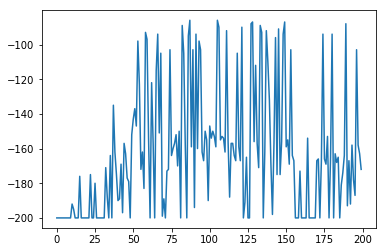

In [17]:
net_kwargs = {'hidden_sizes' : [16,], 'learning_rate' : 0.005}
agent = DoubleDQNAgent(env, net_kwargs=net_kwargs)

# 训练
episodes = 200
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [18]:
env.close()